In [66]:
import math
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
import os 

import laplace

In [67]:
%config InlineBackend.figure_format = 'retina'
sns.set(style="darkgrid")
matplotlib.rcParams['figure.dpi']= 200
sns.set(style="white")

# Bayesian Linear Regression

In [68]:
import numpy as np


def func(x):
    return np.sin(2 * np.pi * x)

#def func(x):
#    return 23
    


size = 200
rng = np.random.RandomState(1234)
x_train = rng.uniform(0.0, 1.0, size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0.0, 1.0, 100)


In [69]:
func(1)

-2.4492935982947064e-16

In [70]:
'''def func(x):
    return np.sin(2 * np.pi * x ** 2) - np.tan(x)


size = 200
rng = np.random.RandomState(1234)
x_train = rng.uniform(0.0, 1.0, size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0.0, 1.0, 100)'''

'def func(x):\n    return np.sin(2 * np.pi * x ** 2) - np.tan(x)\n\n\nsize = 200\nrng = np.random.RandomState(1234)\nx_train = rng.uniform(0.0, 1.0, size)\ny_train = func(x_train) + rng.normal(scale=0.1, size=size)\nx_test = np.linspace(0.0, 1.0, 100)'

In [71]:
from sklearn.linear_model import BayesianRidge

n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)

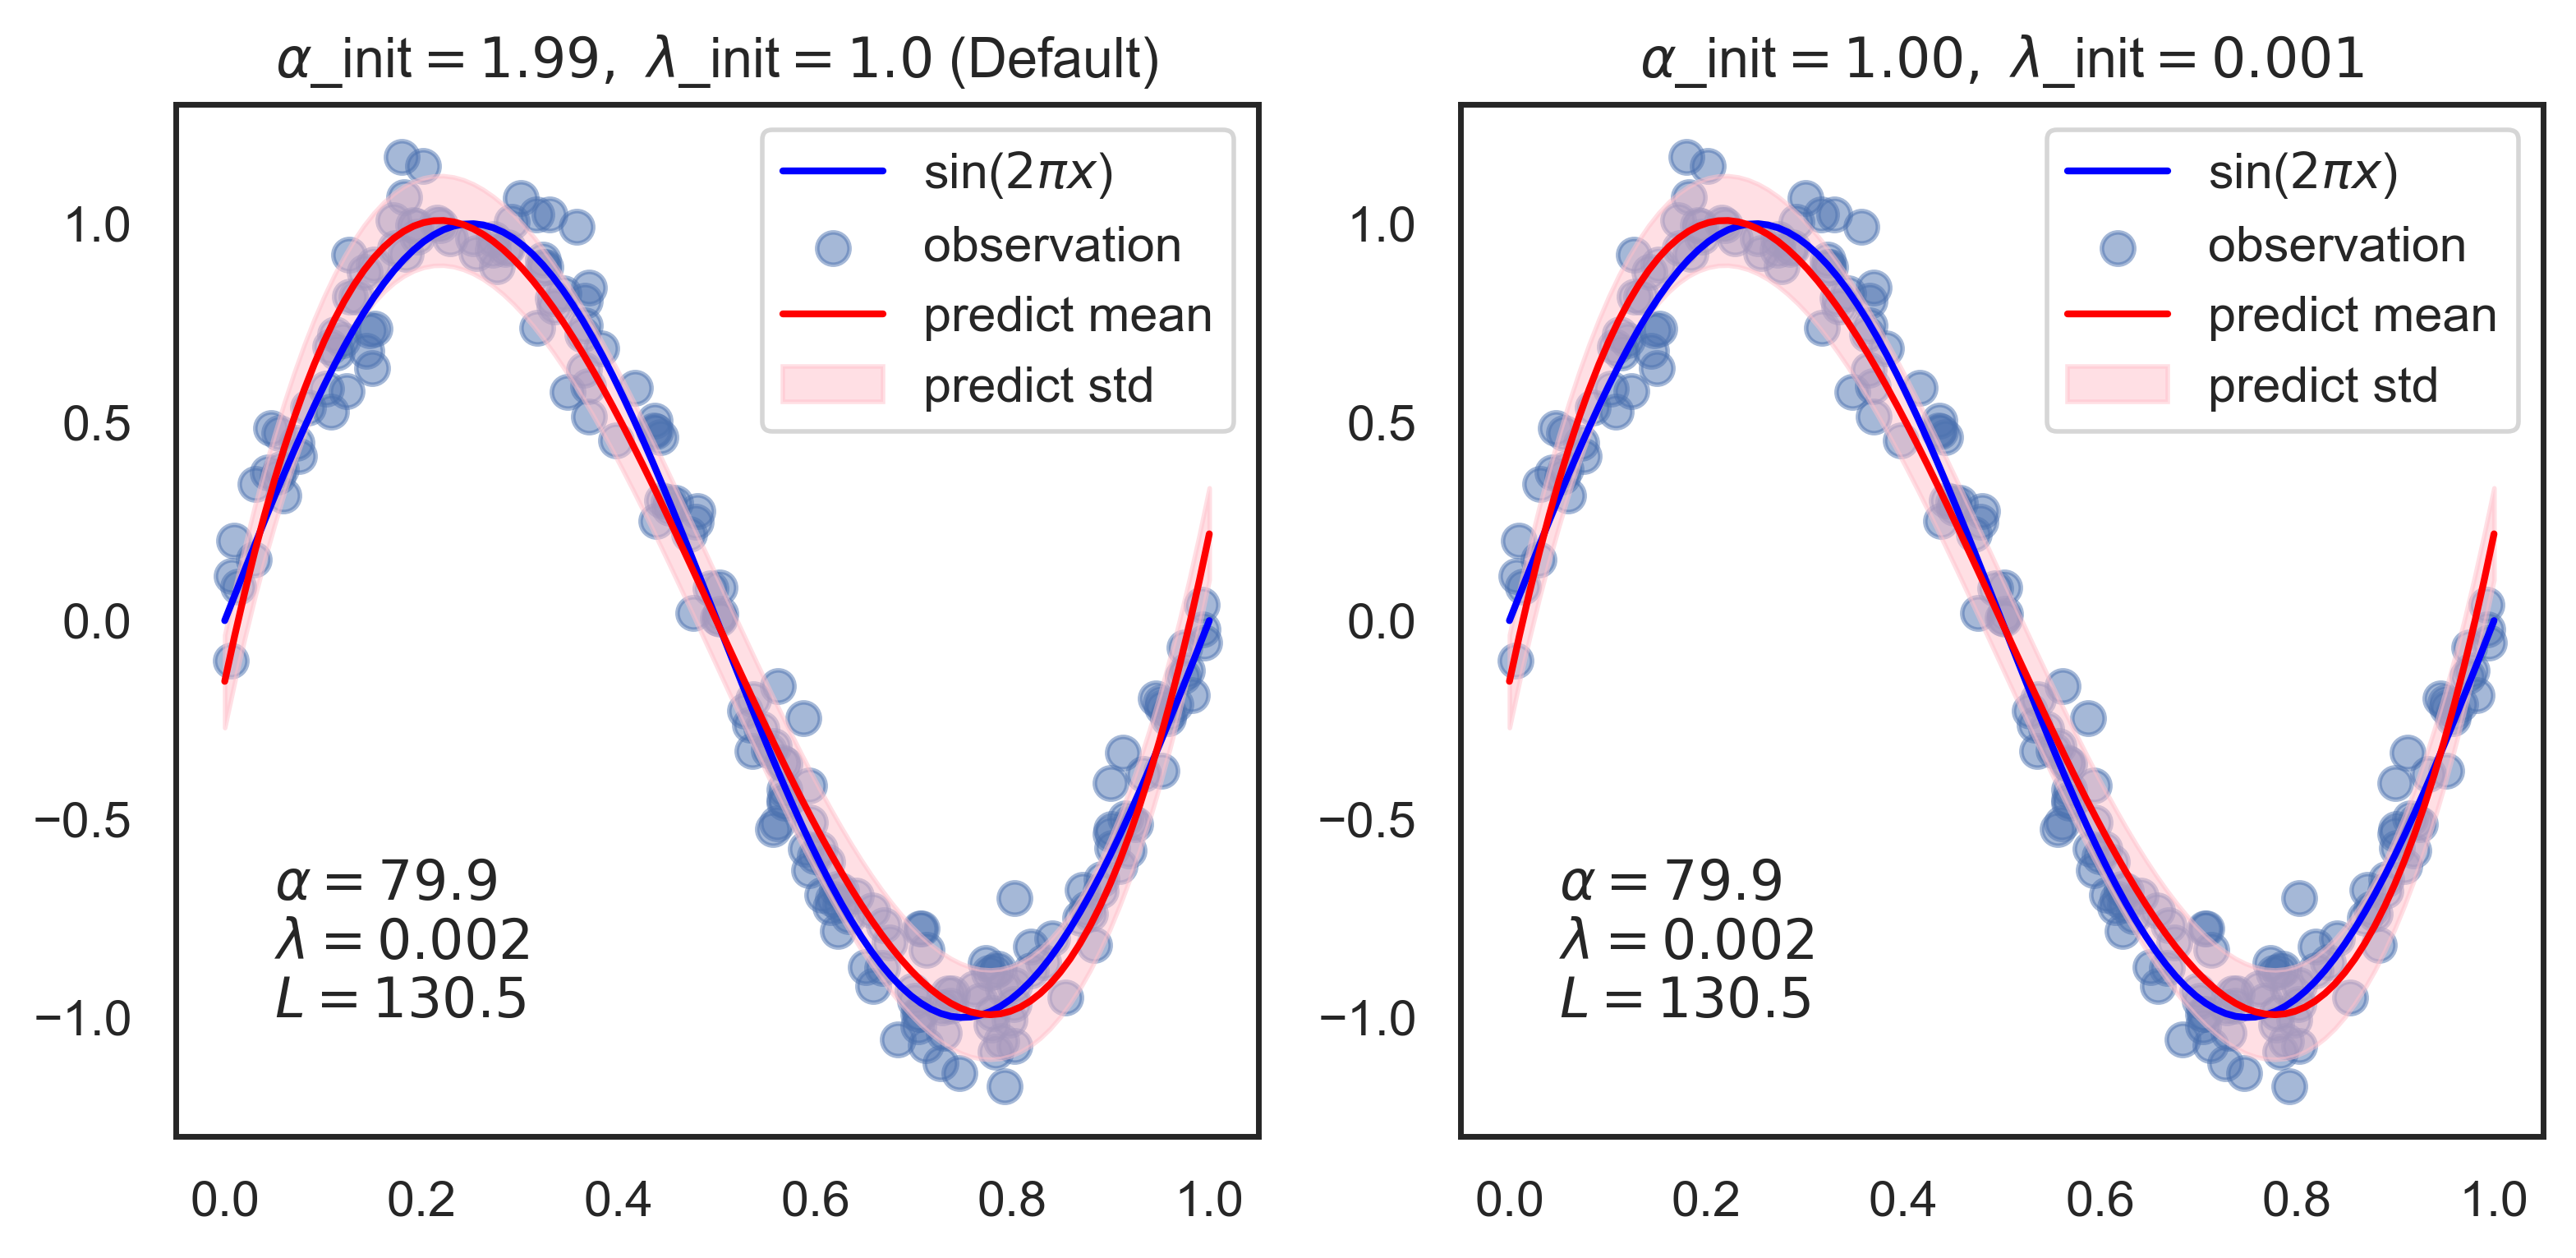

In [72]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.0]  # Default values
    elif i == 1:
        init = [1.0, 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(
        x_test, ymean - ystd, ymean + ystd, color="pink", alpha=0.5, label="predict std"
    )
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
        reg.alpha_, reg.lambda_, reg.scores_[-1]
    )
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()

# SVGD and SVN implementations

In [73]:
import torch
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, x, y):
        # Convert the numpy arrays to PyTorch tensors
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        # Return the size of the dataset
        return len(self.x)

    def __getitem__(self, idx):
        # Retrieve an item by index
        return self.x[idx], self.y[idx]

In [74]:
import matplotlib.pyplot as plt

def plot_functions(x_test, ensemble, func):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for i, ax in enumerate(axes):
        
        
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

        y_ensemble = ensemble.forward(x_test_tensor)

        # Calculate mean and std of predictions
        y_mean = torch.mean(y_ensemble[0], dim=0).squeeze()  # Mean across particles
        y_std = torch.std(y_ensemble[0], dim=0).squeeze()  # Std deviation across particles
        
        ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
        ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
        
        ax.plot(x_test_tensor, y_mean, color="red", label="predict mean")

        # Plot ensemble predictions
        for i in range(y_ensemble[0].shape[0]):
            ax.plot(x_test, y_ensemble[0][i].numpy().squeeze(), linestyle='--', alpha=0.5, label=f"Member {i+1}")


        ax.fill_between(
            x_test, y_mean - y_std, y_mean + y_std, color="pink", alpha=0.5, label="predict std"
        )
        #ax.set_ylim(-1.3, 1.3)
        ax.legend()
        title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
        if i == 0:
            title += " (Default)"
        ax.set_title(title, fontsize=12)
        text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
            reg.alpha_, reg.lambda_, reg.scores_[-1]
        )
        ax.text(0.05, -1.0, text, fontsize=12)

    plt.tight_layout()
    plt.show()

In [75]:
import matplotlib.pyplot as plt

def plot_modellist(x_test, modellist, func, dim_problem=1):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for i, ax in enumerate(axes):
        
        n_particles = len(modellist)
        
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

        #y_ensemble = ensemble.forward(x_test_tensor)

        
        with torch.no_grad():  # Ensure no gradients are computed
            pred_list = []
            for model in modellist:
                pred_list.append(model.forward(x_test_tensor))
            pred = torch.cat(pred_list, dim=0)
            y_ensemble = pred.view(n_particles, -1, 1)  # Adjust dim_problem if necessary

            # Calculate mean and std of predictions
            y_mean = torch.mean(y_ensemble, dim=0).squeeze()  # Mean across particles
            y_std = torch.std(y_ensemble, dim=0).squeeze()  # Std deviation across particles
            
        
        ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
        ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
        
        #ax.plot(x_test_tensor, y_mean, color="red", label="predict mean")
        ax.plot(x_test_tensor, y_mean, color="red", label="predict mean")


        # Plot ensemble predictions
        for i in range(y_ensemble.shape[0]):
            ax.plot(x_test, y_ensemble[i].numpy().squeeze(), linestyle='--', alpha=0.5, label=f"Member {i+1}")


        ax.fill_between(
            x_test, y_mean - y_std, y_mean + y_std, color="pink", alpha=0.5, label="predict std"
        )
        #ax.set_ylim(-1.3, 1.3)
        ax.legend()
        title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
        if i == 0:
            title += " (Default)"
        ax.set_title(title, fontsize=12)
        text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
            reg.alpha_, reg.lambda_, reg.scores_[-1]
        )
        ax.text(0.05, -1.0, text, fontsize=12)

    plt.tight_layout()
    plt.show()

In [76]:

import torch
import torch.nn as nn

class LinearWithOutput(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    @property
    def weight(self):
        return self.linear.weight

    @weight.setter
    def weight(self, value):
        self.linear.weight = value

    @property
    def bias(self):
        return self.linear.bias

    @bias.setter
    def bias(self, value):
        self.linear.bias = value
        

    def forward(self, x):
        output = self.linear(x)
        # Here you can do something with output if needed
        return output

In [77]:
import torch.nn as nn
import torch.nn.functional as F

class SequentialNet(nn.Module):
    def __init__(self, layer_sizes, classification=False, act=F.relu, d_logits=False, out_act=None, bias=True, no_weights = True):
        super(SequentialNet, self).__init__()
        self.classification = classification
        self.d_logits = d_logits
        self.out_act = out_act
        self.layers = self._build_layers(layer_sizes, act, bias)

        self.num_params = sum(p.numel() for p in self.parameters())

        self.param_shapes = [list(i.shape) for i in self.parameters()]

        self._weights = None
        if no_weights:
            return

        ### Define and initialize network weights.
        # Each odd entry of this list will contain a weight Tensor and each
        # even entry a bias vector.
        self._weights = nn.ParameterList()

        for i, dims in enumerate(self.param_shapes):
            self._weights.append(nn.Parameter(torch.Tensor(*dims),
                                              requires_grad=True))


        for i in range(0, len(self._weights), 2 if bias else 1):
            if bias:
                self.init_params(self._weights[i], self._weights[i + 1])
            else:
                self.init_params(self._weights[i])


    def init_params(self,weights, bias=None):
        """Initialize the weights and biases of a linear or (transpose) conv layer.

        Note, the implementation is based on the method "reset_parameters()",
        that defines the original PyTorch initialization for a linear or
        convolutional layer, resp. The implementations can be found here:

            https://git.io/fhnxV
        Args:
            weights: The weight tensor to be initialized.
            bias (optional): The bias tensor to be initialized.
        """
        nn.init.kaiming_uniform_(weights, a=math.sqrt(5))
        if bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weights)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(bias, -bound, bound)
        
    def _build_layers(self, layer_sizes, act, bias):
        modules = []
        for i in range(len(layer_sizes) - 1):
            modules.append(LinearWithOutput(layer_sizes[i], layer_sizes[i + 1], bias=bias))
            # Add activation function for all but the last layer.
            if i < len(layer_sizes) - 2 or self.d_logits:
                modules.append(act)
        # If out_act is specified, add it to the last layer.
        if self.out_act is not None:
            modules.append(self.out_act)
        return nn.Sequential(*modules)
    
    #@property
    #def num_params(self):
    #    return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x, weights=None):
        for i, layer in enumerate(self.layers):
            if weights is not None:
                # Apply custom weights if provided
                with torch.no_grad():
                    layer.weight.data = weights[2*i].data
                    if layer.bias is not None:
                        layer.bias.data = weights[2*i + 1].data
            x = layer(x)
            if i < len(self.layers) - 1:  # Apply activation function except for the output layer
                x = self.act(x)
        
        if self.out_act is not None:
            x = self.out_act(x)
        
        return x

layer sizes:  [1, 8, 8, 1]
parameters in Net:  97
initialised particles:  torch.Size([3, 97])
W shape before training:  torch.Size([3, 97])
-------------------------Start training-------------------------
Epoch 0


100%|██████████| 40/40 [00:00<00:00, 1371.31it/s]


Train Epoch 0, Loss 1 = -125866.0391, Loss 2 = -46842.7383, Loss 3 = -24639.3770


100%|██████████| 10/10 [00:00<00:00, 4992.62it/s]


Test Epoch 0: MSE: 0.0607, RMSE: 0.2464
Epoch 1


100%|██████████| 40/40 [00:00<00:00, 1569.31it/s]


Train Epoch 1, Loss 1 = -103718.5234, Loss 2 = -32429.5840, Loss 3 = -35172.3320


100%|██████████| 10/10 [00:00<00:00, 4653.62it/s]


Test Epoch 1: MSE: 0.2125, RMSE: 0.4610
Epoch 2


100%|██████████| 40/40 [00:00<00:00, 1499.88it/s]


Train Epoch 2, Loss 1 = -95725.5547, Loss 2 = -49179.4570, Loss 3 = -14562.3018


100%|██████████| 10/10 [00:00<00:00, 4614.70it/s]


Test Epoch 2: MSE: 0.0710, RMSE: 0.2665
Epoch 3


100%|██████████| 40/40 [00:00<00:00, 1492.54it/s]


Train Epoch 3, Loss 1 = -88571.0469, Loss 2 = -37865.0664, Loss 3 = -19870.2734


100%|██████████| 10/10 [00:00<00:00, 4710.58it/s]


Test Epoch 3: MSE: 0.0958, RMSE: 0.3095
Epoch 4


100%|██████████| 40/40 [00:00<00:00, 1624.42it/s]


Train Epoch 4, Loss 1 = -115553.7656, Loss 2 = -12435.2393, Loss 3 = -25944.1504


100%|██████████| 10/10 [00:00<00:00, 4914.24it/s]


Test Epoch 4: MSE: 0.1864, RMSE: 0.4317
Epoch 5


100%|██████████| 40/40 [00:00<00:00, 1541.97it/s]


Train Epoch 5, Loss 1 = -89972.7500, Loss 2 = -33711.9570, Loss 3 = -15512.5664


100%|██████████| 10/10 [00:00<00:00, 4748.99it/s]


Test Epoch 5: MSE: 0.2258, RMSE: 0.4752
Epoch 6


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch 6, Loss 1 = -95413.8203, Loss 2 = -31064.3340, Loss 3 = -11862.2207


100%|██████████| 10/10 [00:00<00:00, 3414.17it/s]


Test Epoch 6: MSE: 0.1378, RMSE: 0.3712
Epoch 7


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch 7, Loss 1 = -98969.8828, Loss 2 = -13884.8242, Loss 3 = -22653.9453


100%|██████████| 10/10 [00:00<00:00, 4965.44it/s]


Test Epoch 7: MSE: 0.2070, RMSE: 0.4550
Epoch 8


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch 8, Loss 1 = -64837.3359, Loss 2 = -23212.1914, Loss 3 = -8946.5791


100%|██████████| 10/10 [00:00<00:00, 4335.20it/s]


Test Epoch 8: MSE: 0.0336, RMSE: 0.1833
Epoch 9


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch 9, Loss 1 = -94849.0781, Loss 2 = -37045.8984, Loss 3 = -7557.1313


100%|██████████| 10/10 [00:00<00:00, 4275.10it/s]


Test Epoch 9: MSE: 0.1472, RMSE: 0.3837


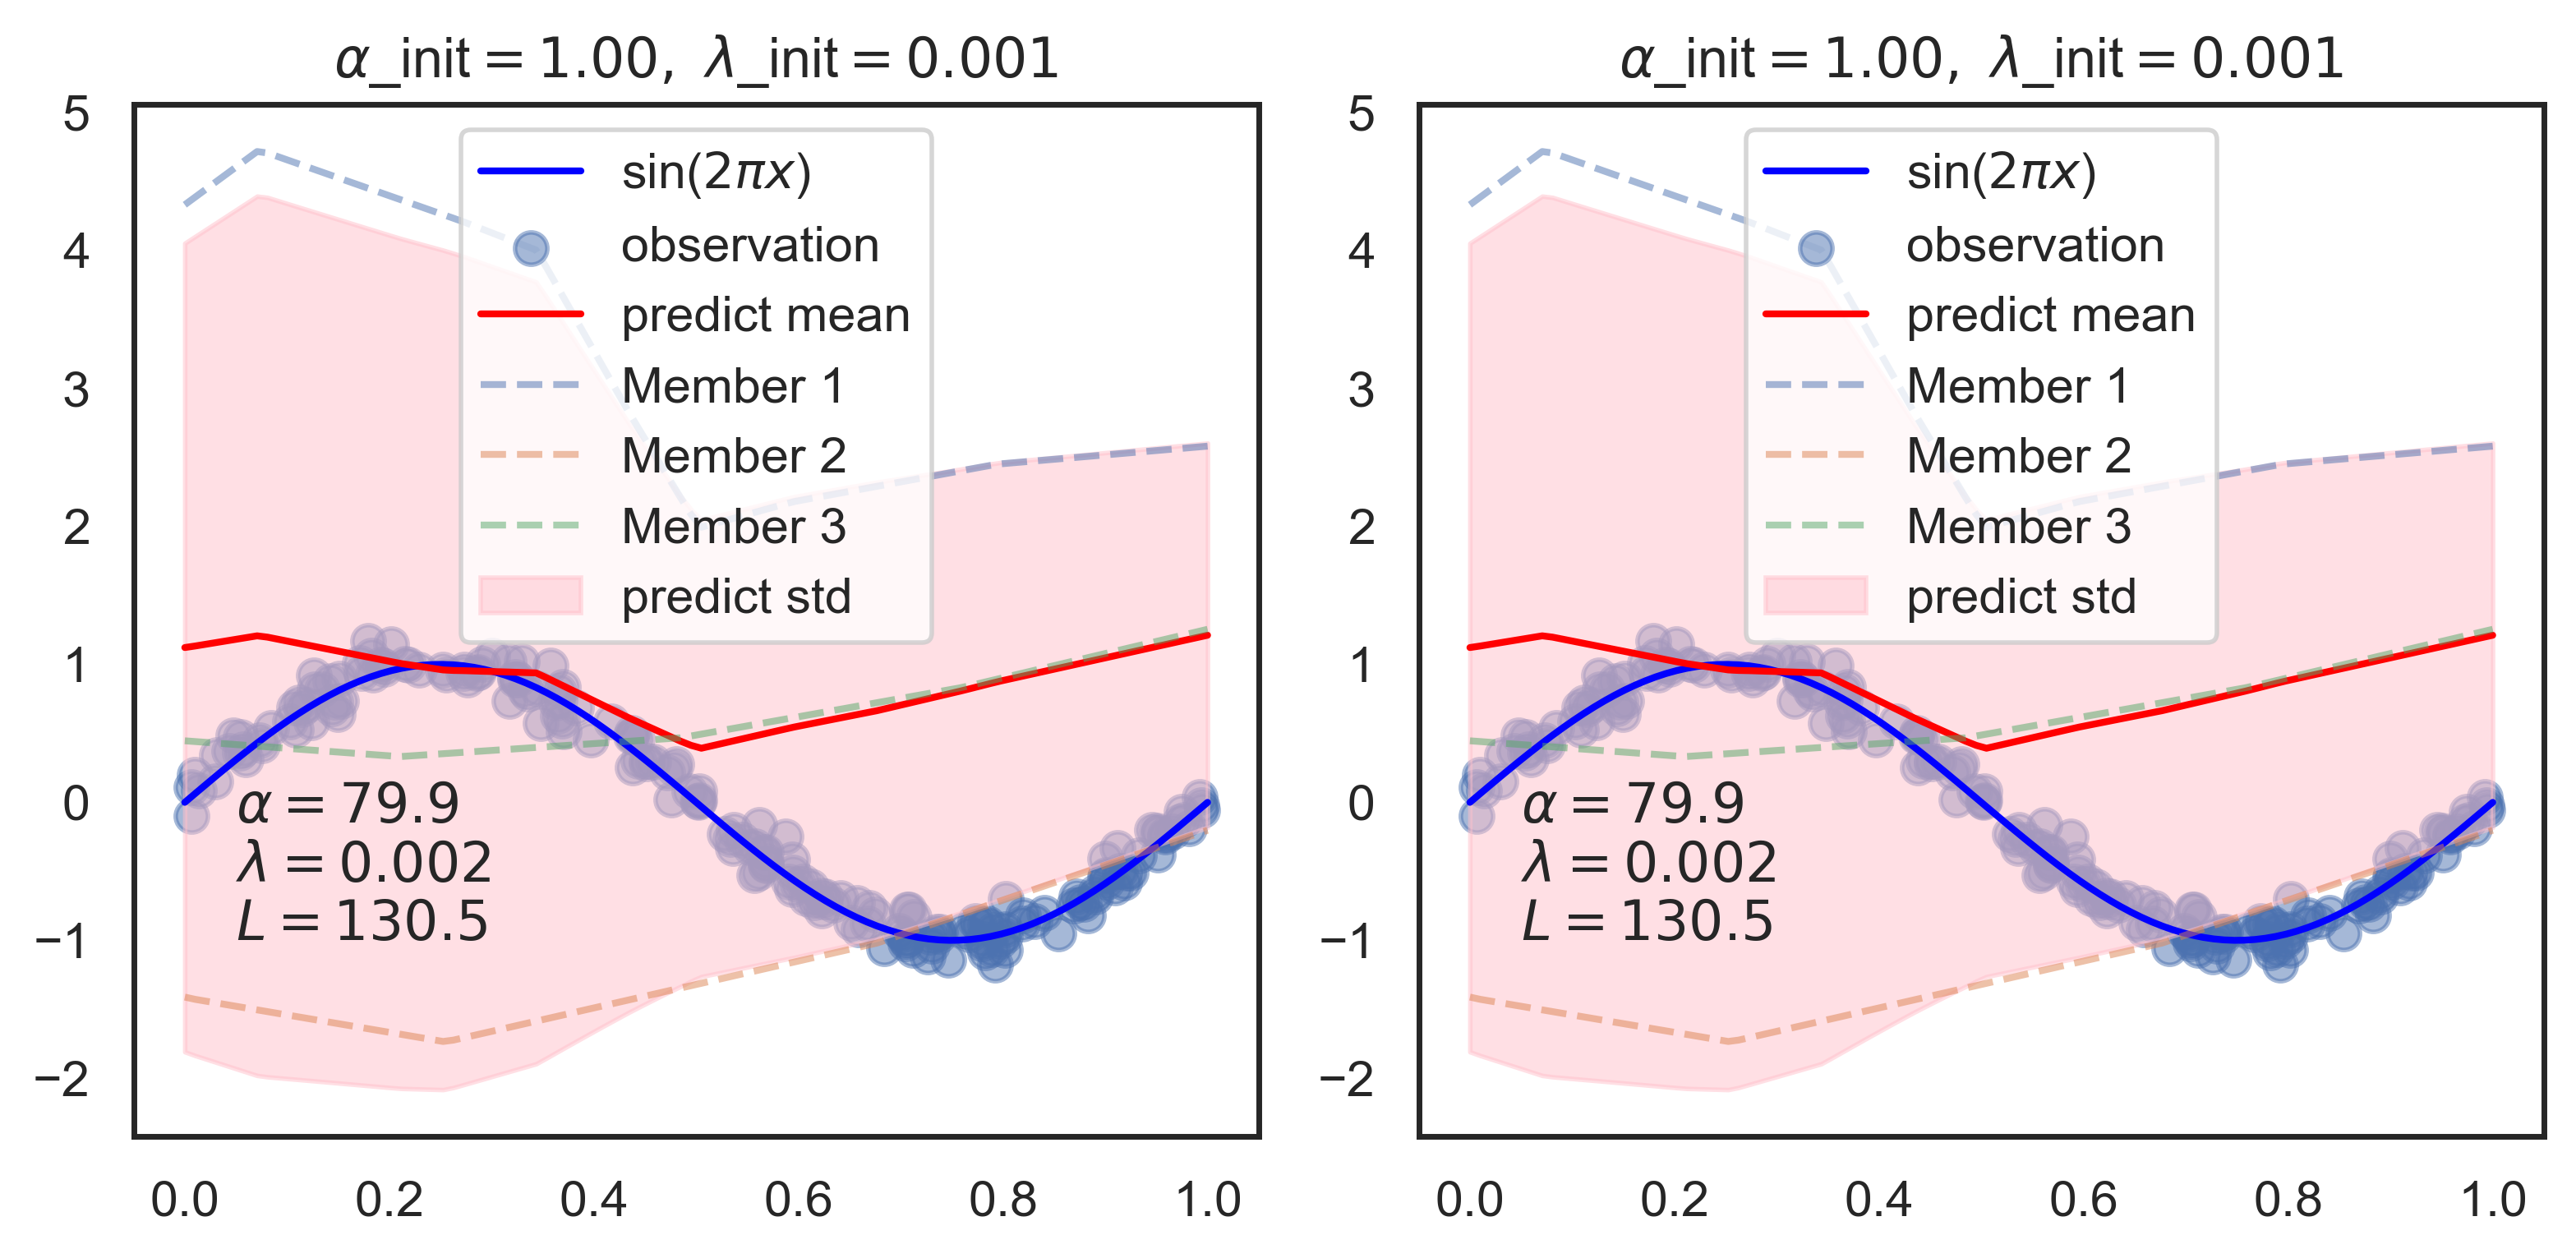

In [83]:
import torch.nn.functional as F

from utils.ensemble import Ensemble
from utils.kernel import RBF
from models.mlp import Net 
from train.train_svgd import train
import torch.utils.data as data_utils

from backpack import extend

# Creating an instance of the SineDataset
sine_dataset = Dataset(x_train, y_train)



layer_sizes = [1, 8 ,8, 1]

print("layer sizes: ", layer_sizes)



mnet = Net(layer_sizes, classification = False, act=F.relu, out_act = None, bias = True, no_weights=False).to(device)

model = torch.nn.Sequential(
    torch.nn.Linear(layer_sizes[0], layer_sizes[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_sizes[1], 1),
)

#mnet = SequentialNet(layer_sizes, classification = False, act=F.relu, out_act = None, bias = True, no_weights=False).to(device)

#input_size = 1  # Because each input data point has 1 feature
#output_size = 1  # Assuming you're predicting a single value

#mnet = extend(SequentialNet(layer_sizes, classification = False, act=F.relu, out_act = None, bias = True, no_weights=False).to(device))

print("parameters in Net: ", mnet.num_params)
#print([p for p in mnet.parameters()])

n_particles = 3

ensemble = Ensemble(device = device, net=mnet, n_particles = n_particles)

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the data into training and evaluation sets
x_train_split, x_eval_split, y_train_split, y_eval_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Create instances of the SineDataset for each set
train_dataset = Dataset(x_train_split, y_train_split)
eval_dataset = Dataset(x_eval_split, y_eval_split)


# Creating a DataLoaders
batch_size = 4  # Define your batch size
shuffle = False  # Shuffle the data every epoch
num_workers = 1  # How many subprocesses to use for data loading
n_data = 200
sigma_noise=0.3


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

K = RBF(0.001)
lr = 1e-4

num_epochs = 10
metrics = train(ensemble, lr, num_epochs, train_dataloader, eval_dataloader, device, use_SVN=False)



#metrics = train(ensemble, lr, num_epochs, train_loader, train_loader, device, use_SVN=True)

plot_functions(x_test, ensemble, func)


layer sizes:  [1, 1]
number of parameters per model 2
-------------------------Start training-------------------------
Epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 0, Loss 0 = 0.1325, Loss 1 = 0.4896, Loss 2 = 0.4159, Loss 3 = 0.6169


100%|██████████| 5/5 [00:00<00:00, 4481.09it/s]
/Users/klemens.floege/Desktop/Dev/laplace_SVN/train/train_modellist.py:215: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  overall_rmse = torch.sqrt(torch.tensor(overall_mse))


Test Epoch 0: MSE: 0.2425, RMSE: 0.4924
Epoch 1


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 1, Loss 0 = 0.1958, Loss 1 = 0.5019, Loss 2 = 0.4473, Loss 3 = 0.5844


100%|██████████| 5/5 [00:00<00:00, 4902.18it/s]


Test Epoch 1: MSE: 0.1100, RMSE: 0.3317
Epoch 2


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 2, Loss 0 = 0.1552, Loss 1 = 0.1920, Loss 2 = 0.1755, Loss 3 = 0.2072


100%|██████████| 5/5 [00:00<00:00, 4582.94it/s]


Test Epoch 2: MSE: 0.1501, RMSE: 0.3875
Epoch 3


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 3, Loss 0 = 0.1844, Loss 1 = 0.6160, Loss 2 = 0.5733, Loss 3 = 0.5454


100%|██████████| 5/5 [00:00<00:00, 4621.31it/s]


Test Epoch 3: MSE: 0.2821, RMSE: 0.5311
Epoch 4


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 4, Loss 0 = 0.2058, Loss 1 = 0.6172, Loss 2 = 0.5324, Loss 3 = 0.7844


100%|██████████| 5/5 [00:00<00:00, 4694.77it/s]


Test Epoch 4: MSE: 0.1532, RMSE: 0.3914
Epoch 5


100%|██████████| 20/20 [00:00<00:00, 205.09it/s]


Train Epoch 5, Loss 0 = 0.1391, Loss 1 = 0.8726, Loss 2 = 0.7672, Loss 3 = 0.9113


100%|██████████| 5/5 [00:00<00:00, 4287.78it/s]


Test Epoch 5: MSE: 0.0773, RMSE: 0.2780
Epoch 6


100%|██████████| 20/20 [00:00<00:00, 206.47it/s]


Train Epoch 6, Loss 0 = 0.1866, Loss 1 = 0.7315, Loss 2 = 0.6617, Loss 3 = 0.7380


100%|██████████| 5/5 [00:00<00:00, 3997.62it/s]


Test Epoch 6: MSE: 0.2013, RMSE: 0.4486
Epoch 7


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 7, Loss 0 = 0.2836, Loss 1 = 0.6581, Loss 2 = 0.5955, Loss 3 = 0.7293

100%|██████████| 20/20 [00:00<00:00, 235.37it/s]


100%|██████████| 5/5 [00:00<00:00, 3933.88it/s]


Test Epoch 7: MSE: 0.1463, RMSE: 0.3825
Epoch 8


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 8, Loss 0 = 0.0560, Loss 1 = 0.2686, Loss 2 = 0.2043, Loss 3 = 0.5039


100%|██████████| 5/5 [00:00<00:00, 4652.07it/s]


Test Epoch 8: MSE: 0.0779, RMSE: 0.2792
Epoch 9


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch 9, Loss 0 = 0.2448, Loss 1 = 0.8616, Loss 2 = 0.7741, Loss 3 = 0.8969


100%|██████████| 5/5 [00:00<00:00, 4730.77it/s]


Test Epoch 9: MSE: 0.0747, RMSE: 0.2733


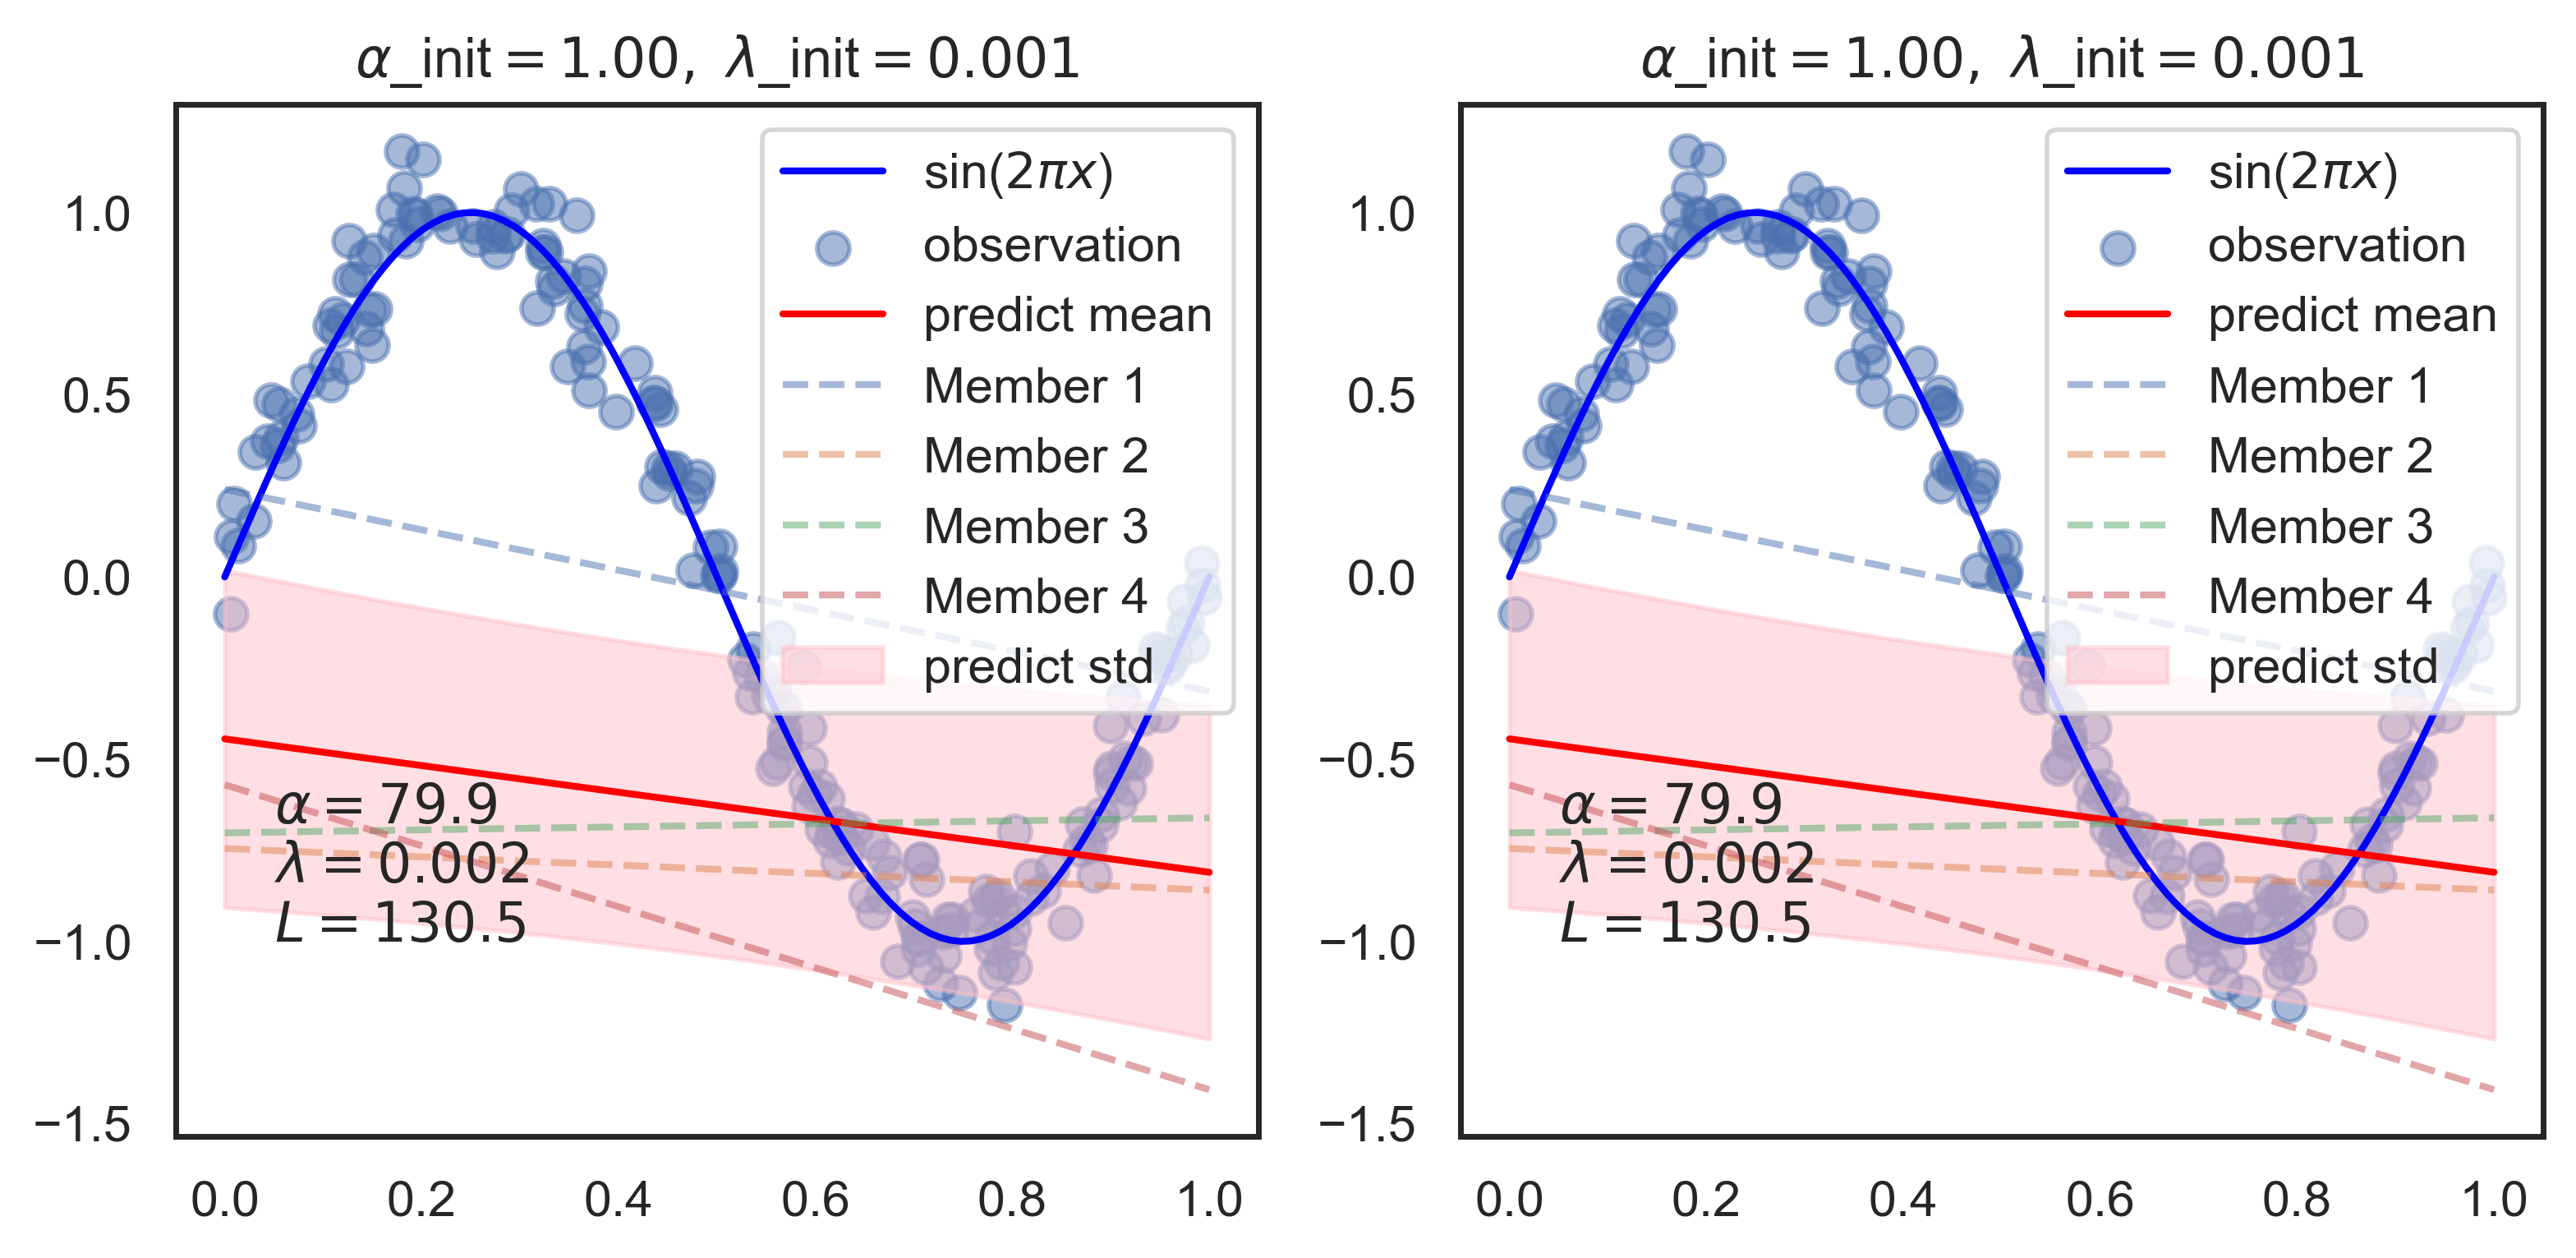

In [79]:
import torch.nn.functional as F

from utils.ensemble import Ensemble
from utils.kernel import RBF
from models.mlp import Net 
from train.train_modellist import train_modellist
import torch.utils.data as data_utils

from backpack import extend

# Creating an instance of the SineDataset
sine_dataset = Dataset(x_train, y_train)



layer_sizes = [1, 1]

print("layer sizes: ", layer_sizes)

n_particles = 4

modellist = []

for _ in range(n_particles):
    layers = []
    for i in range(len(layer_sizes) - 1):
        # Add linear layer
        layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        # Add ReLU activation, except for the output layer
        if i < len(layer_sizes) - 2:
            layers.append(torch.nn.ReLU())
    model = torch.nn.Sequential(*layers)
    modellist.append(model)


#ensemble = Ensemble(device = device, net=mnet, n_particles = n_particles)

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the data into training and evaluation sets
x_train_split, x_eval_split, y_train_split, y_eval_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Create instances of the SineDataset for each set
train_dataset = Dataset(x_train_split, y_train_split)
eval_dataset = Dataset(x_eval_split, y_eval_split)


# Creating a DataLoaders
batch_size = 8  # Define your batch size
shuffle = False  # Shuffle the data every epoch
num_workers = 1  # How many subprocesses to use for data loading
n_data = 200
sigma_noise=0.3


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

K = RBF(0.001)
lr = 1e-4

num_epochs = 10

metrics = train_modellist(modellist, lr, num_epochs, train_dataloader, eval_dataloader, device, use_SVN=True)


plot_modellist(x_test, modellist, func)
